In [1]:
import os
import re
import pickle
import time
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix

%matplotlib inline

# Custom modules
import const
import func

## Load data

In [3]:
const.TRAIN_FILES

['train_numeric', 'train_categorical_to_num', 'train_date']

In [4]:
const.TEST_FILES

['test_numeric', 'test_categorical_to_num', 'test_date']

In [5]:
# Get response
y, n_1, n_0 = func.get_responses()
print('Samples with R=0: {}'.format(len(n_0)))
print('Samples with R=1: {}'.format(len(n_1)))
y.head(3)

Samples with Response=0: 1176868
Samples with Response=1: 6879


,Response
Id,
4,0
6,0
7,0


In [6]:
# Get IDs of train/test data
id_test = func.read_first_column(const.TEST_FILES[0])
id_train = func.read_first_column(const.TRAIN_FILES[0])

id_all = pd.concat([id_test, id_train], axis=0)

In [7]:
# Check that all IDs are same in files
#id_test2 = func.read_first_column(const.TEST_FILES[1])
#id_test3 = func.read_first_column(const.TEST_FILES[2])
#print set(id_test) - set(id_test2) # -> Empty set
#print set(id_test) - set(id_test3) # -> Empty set

In [8]:
id_all.sort_values('Id').diff().Id.value_counts() # Should be just a single value 

1.0    2367494
Name: Id, dtype: int64

In [9]:
# Add response to train samples
id_all.set_index('Id', inplace=True)
id_all['Response'] = y
id_all.sort_index(inplace=True)

In [10]:
id_all.head(5)

,Response
Id,
1,NaN
2,NaN
3,NaN
4,0.0
5,NaN


## Demonstrate ID behavior

In [11]:
# Select all features with R=1
id_R1 = id_all[id_all.Response==1].reset_index()

In [12]:
id_R1.head()

,Id,Response
0,1053,1.0
1,1250,1.0
2,1350,1.0
3,1793,1.0
4,2347,1.0


If occurence of samples with R=1 happens completely random you would expect a distribution of difference between IDs of samples where very longs periods between events are less likely to occurs. If you plot an histogram of the ID differences this looks correct.

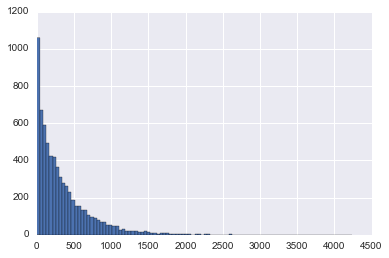

In [13]:
id_R1.diff().Id.hist(bins=100)

However, if you zoom in on the left part of the histogram, you suddenly see a peak around n=1 that is much higher than expected. So for some reason, a sample directly after a sample with R=1 a higher chance of having R=1.

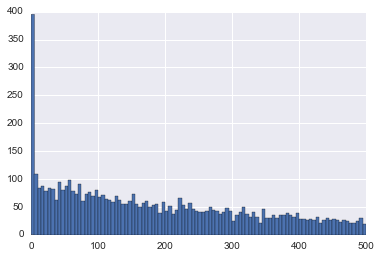

In [14]:
id_R1.diff().Id.hist(bins=100, range=(0,500))

Another way too look at this (Thanks Rodolphe) is looking at the autocorrelation function. This should be zero everywhere, except for a lag of 1.

In [15]:
ac = [pd.Series(id_all.Response.values).autocorr(n) for n in range(25)]

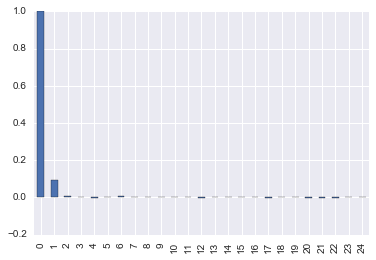

In [16]:
pd.Series(ac).plot(kind='bar')

There is our peak at t=1 again! (Peak at t=0 is by definition zero.)

## Creating features based on this observation

So if the previous sample (by ID) has a R=1, the next sample has a higher probability of having R=1. So we can use the Response of the previous sample-ID as a feature. We can simply calculate that by shift the current values of response (and replace NaN by zeros).

In [17]:
id_all['ID_feature'] = id_all['Response'].shift(1).fillna(0)

In [18]:
# Check by couple of examples
id_all[id_all.Response==1].index

Int64Index([   1053,    1250,    1350,    1793,    2347,    3527,    3585,
               4104,    4978,    4998,
            ...
            2365611, 2365624, 2365868, 2365878, 2365879, 2366099, 2366124,
            2366209, 2366505, 2366692],
           dtype='int64', name=u'Id', length=6879)

In [19]:
# NaN are test samples
# So sample 4999 has a higher chance of having Response because the sample 4998 has R=1
n=4998
id_all.iloc[n-3:n+3]

,Response,ID_feature
Id,,
4996,0.0,0.0
4997,NaN,0.0
4998,1.0,0.0
4999,NaN,1.0
5000,NaN,0.0
5001,0.0,0.0


In [20]:
# NaN are test samples
# So sample 4999 has a higher chance of having Response because the sample 4998 has R=1
n=2365868
id_all.iloc[n-3:n+3]

,Response,ID_feature
Id,,
2365866,0.0,0.0
2365867,0.0,0.0
2365868,1.0,0.0
2365869,NaN,1.0
2365870,0.0,0.0
2365871,NaN,0.0


In [21]:
# We could go a bit further and estimating the sample after this, but I guess this probability is lower than random 
# guessing

In [23]:
# Look at the mean value of ID_feature 
id_all.groupby('Response')['ID_feature'].mean()

Response
0.0    0.002615
1.0    0.050153
Name: ID_feature, dtype: float64

## Store results as feature

In [22]:
id_all['ID_feature'].to_csv('feature_set_ID.csv', index_label='ID')